# Pytorch Dataset Integration Demo 

In [1]:
%cd ..

/raid/localscratch/qfebvre/oceanbench


In [2]:
%pip install torch --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.


In [52]:
import torch
import oceanbench._src.datasets.base as xrda
import oceanbench._src.geoprocessing.validation as val
import oceanbench._src.data as dat

import matplotlib.pyplot as plt
import itertools
import xarray as xr
import collections
import numpy as np

In [4]:
import importlib
importlib.reload(xrda)

<module 'oceanbench._src.datasets.base' from '/raid/localscratch/qfebvre/oceanbench/oceanbench/_src/datasets/base.py'>

## Torch dataset wrapper of the XRDABatcher

In [37]:


class XrTorchDataset(torch.utils.data.Dataset):
    def __init__(self, batcher: xrda.XRDABatcher, item_postpro=None):
        self.batcher = batcher
        self.postpro = item_postpro
        
    def __getitem__(self, idx):
        item = self.batcher[idx].load().values
        if self.postpro:
            item = self.postpro(item)
        return item
    
    def reconstruct_from_batches(self, batches, **rec_kws):
        return self.batcher.reconstruct([*itertools.chain(*batches)], **rec_kws)

    def __len__(self):
        return len(self.batcher)
    

## 1D - 1 variable, Patching Example

In [104]:
# Preparing the training data
raw_data = xr.tutorial.load_dataset("air_temperature")
TrainingItem = collections.namedtuple('TrainingItem', ('air',))
data = (
    raw_data[[*TrainingItem._fields]].isel(lon=5, lat=5, time=slice(0, 1000))
    .sortby('time')
    .to_array().transpose('variable', 'time').load()
)

# Instantiate the patching logic
patches = dict(time=200)
strides = dict(time=160)
batcher = xrda.XRDABatcher(
    da=data,
    patches=patches,
    strides=strides,
    check_full_scan=True
)


# Instantiate the 
torch_ds = XrTorchDataset(batcher, item_postpro=TrainingItem._make)
dataloader = torch.utils.data.DataLoader(torch_ds, batch_size=4, shuffle=False)


items = [torch_ds[i] for i in range(len(torch_ds))]
ex_item = items[0]
batch = next(iter(dataloader))
print(f"Number of items: {len(torch_ds)}")  
print(f"Item shape: {ex_item.air.shape=}")
print(f"Batch shape: {batch.air.shape=}")

Number of items: 6
Item shape: ex_item.air.shape=(200,)
Batch shape: batch.air.shape=torch.Size([4, 200])


### Visualizing the input data

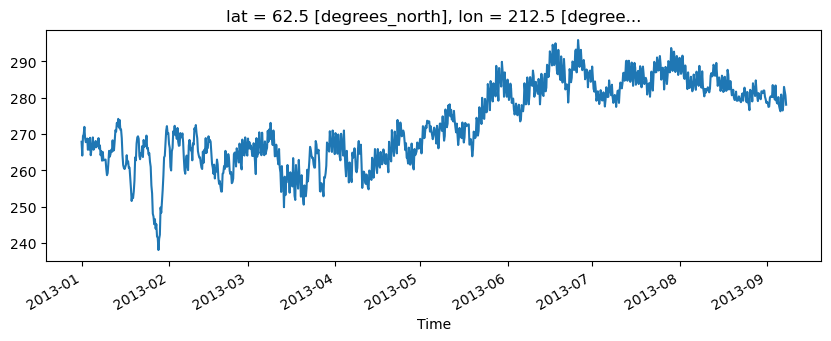

In [124]:
data.plot(figsize=(10, 3))

### Visualizing the items with the overlaps

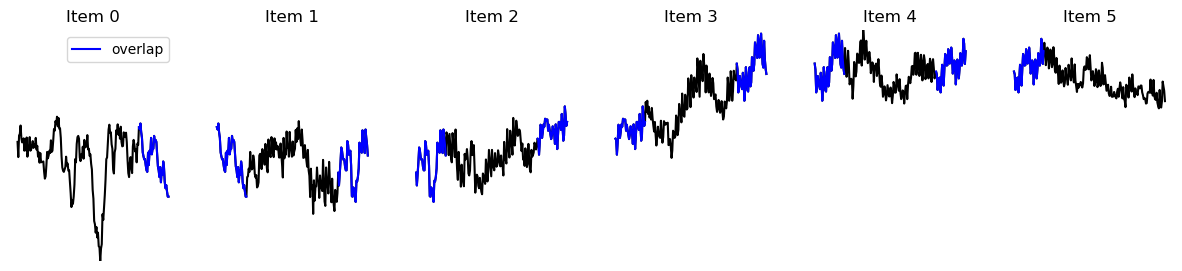

In [122]:
fig, axs = plt.subplots(1, 6, figsize=(15, 3))
for i, (item, ax) in enumerate(zip(items, axs)):
    ax.plot(item.air, 'k',)
    l = None
    if i > 0:
        l, = ax.plot(range(40), item.air[:40], 'b-', label='overlap')
        
    if i < 5:
        l, = ax.plot(range(160, 200), item.air[160:], 'b-', label='overlap')
    if i == 0:
        ax.legend(handles=[l])
    ax.set_title(f'Item {i}')
    ax.set_ylim([data.min(), data.max()])
    ax.set_xticks([], labels=None)
    ax.set_axis_off()
    ax.set_yticks([], labels=None)

## 2D Patching Example

In [26]:
# Preparing the training data
raw_data = xr.tutorial.load_dataset("eraint_uvz")
TrainingItem = collections.namedtuple('TrainingItem', ('u', 'v'))
data = (
    raw_data[[*TrainingItem._fields]].isel(longitude=slice(None, 400), latitude=slice(None, 200), month=0, level=0)
    .sortby('longitude').sortby('latitude')
    .to_array().transpose('variable', 'latitude', 'longitude').load()
)

# Instantiate the patching logic
patches = dict(longitude=100, latitude=50)
batcher = xrda.XRDABatcher(
    da=data,
    patches=patches,
    strides=patches, # No overlap
    check_full_scan=True
)


# Instantiate the 
torch_ds = XrTorchDataset(batcher, item_postpro=TrainingItem._make)
dataloader = torch.utils.data.DataLoader(torch_ds, batch_size=4, shuffle=False)


items = [torch_ds[i] for i in range(len(torch_ds))]
ex_item = items[0]
batch = next(iter(dataloader))
             
print(f"Item shape: {ex_item.u.shape=}, {ex_item.v.shape=}")
print(f"Batch shape: {batch.u.shape=}, {batch.v.shape=}")

Item shape: ex_item.u.shape=(50, 100), ex_item.v.shape=(50, 100)
Batch shape: batch.u.shape=torch.Size([4, 50, 100]), batch.v.shape=torch.Size([4, 50, 100])


In [27]:
print(f"Dataset length is {len(torch_ds)}, \n Number of patches per dims are {torch_ds.batcher.da_size}")

Dataset length is 16, 
 Number of patches per dims are OrderedDict([('variable', 1), ('latitude', 4), ('longitude', 4)])


### Vizualizing the patch process

#### Input data:

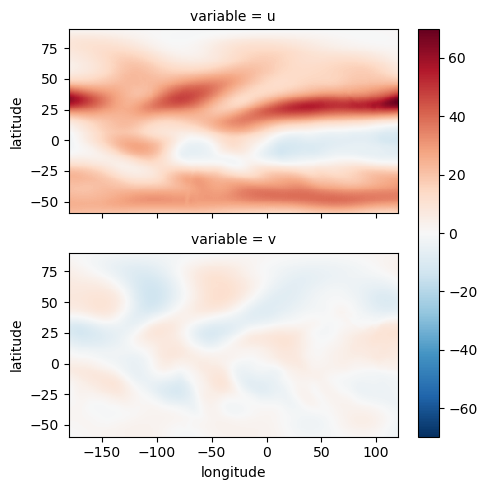

In [28]:
data.plot(row='variable', figsize=(5, 5))

#### Items drawn from the torch dataset

Patches of u


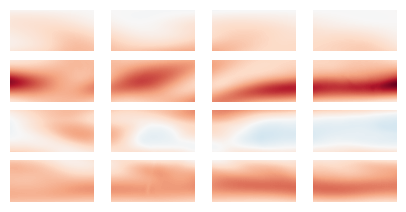



Patches of v


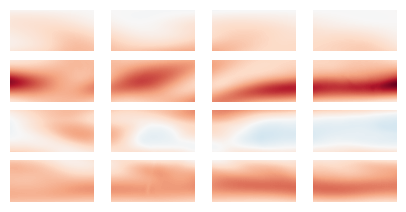

In [89]:
def plot_patches(items_to_plot, nbaxes=(4, 4), figsize=):
    fig, axs = plt.subplots(*nbaxes, figsize=(5, 2.5))

    for item, ax in zip( items_to_plot, [*itertools.chain(*reversed(axs))]):
        ax.imshow(item, cmap='RdBu_r', vmax=70, vmin=-70, origin='lower')
        ax.set_xticks([], labels=None)
        ax.set_axis_off()
        ax.set_yticks([], labels=None)

        
print("Patches of u")
plot_patches([i.u for i in items] )
plt.show()

print("\n\nPatches of v")
plot_patches([i.u for i in items])

#### Reconstructing the amplitude of the speed from the patches

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 156.95it/s]


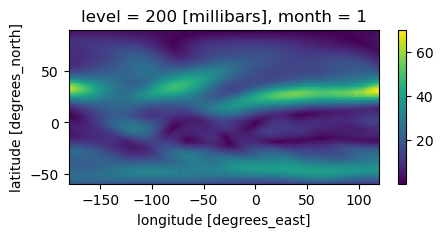

In [65]:
rec_ds = torch_ds.reconstruct_from_batches((np.sqrt(batch.u**2 + batch.v**2) for batch in dataloader), dims_labels=['latitude', 'longitude'])
rec_ds.plot(figsize=(5, 2))

In [ ]:
#### #### Reconstructing the laplacian (~ vorticity) from the patches

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 150.19it/s]


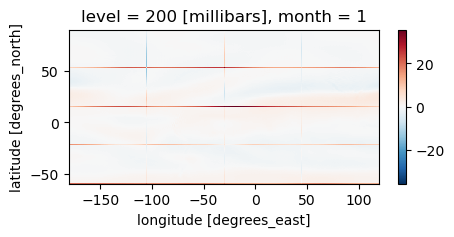

In [72]:
rec_ds = torch_ds.reconstruct_from_batches(((np.diff(batch.u, axis=1, prepend=0) + np.diff(batch.v,axis=2, prepend=0)) for batch in dataloader), dims_labels=['latitude', 'longitude'])
rec_ds.plot(figsize=(5, 2))

**We see that the border of the patches creates artifact during the derivative: We can fix it by using overlapping patches**

#### Solution with overlapping patches (stride smaller than patch size)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 107.60it/s]


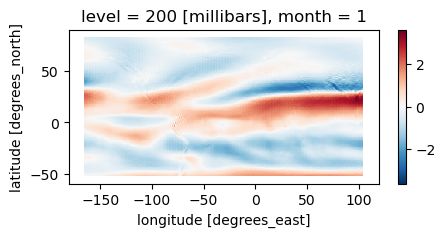

In [91]:

patches = dict(longitude=100, latitude=50)
strides = dict(longitude=60, latitude=30)
batcher = xrda.XRDABatcher(
    da=data, patches=patches, strides=strides, check_full_scan=True
)

rec_weight = np.ones((50, 100)) # Weight for each pixel of one patch
rec_weight[:10] = 0 # do not use the border pixels during the reconstruction
rec_weight[:, :20] = 0
rec_weight[-10:] = 0
rec_weight[:, -20:] = 0

# Instantiate the 
torch_ds = XrTorchDataset(batcher, item_postpro=TrainingItem._make)
dataloader = torch.utils.data.DataLoader(torch_ds, batch_size=4, shuffle=False)
rec_ds = torch_ds.reconstruct_from_batches(
    ((np.diff(batch.u, axis=1, prepend=0) + np.diff(batch.v,axis=2, prepend=0)) for batch in dataloader),
    dims_labels=['latitude', 'longitude'],
    weight=rec_weight,
)
rec_ds.plot(figsize=(5, 2))

Patches of u with overlap


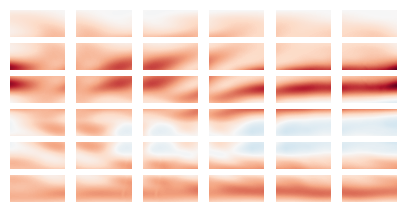



Patches of u with reconstruction mask


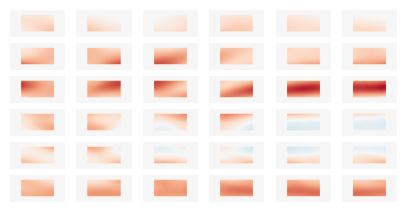

In [94]:
print("Patches of u with overlap")
plot_patches([torch_ds[i].u for i in range(len(torch_ds))], (6,6))
plt.show()
print("\n\nPatches of u with reconstruction mask")
plot_patches([torch_ds[i].u * rec_weight for i in range(len(torch_ds))], (6,6))


In [88]:
len(torch_ds)

36